In [1]:
import igraph as ig
import numpy as np
import pandas as pd
from time import time
import math
import matplotlib.pyplot as plt
from auxiliar_bb import noise_corrected, disparity
from auxiliar_projections_large import apply_projection

In [2]:
FILENAME = "binet-AMZ-Rw.graphml"
PROJ_NAME = ["simple", "vector", "master", "hyper", "resall"]

In [3]:
###### ****** Read BI GRAPH ****** ######
g = ig.read(FILENAME)
del g.es["weight"]
print(g.summary())
print()

top_nodes = g.vs.select(type=0)
bot_nodes = g.vs.select(type=1)

if(g.is_bipartite()): # Check if the the graph is bipartite
    print("The graph IS bipartite")
else:
    print("The graph IS NOT bipartite")
    exit()
print("|U|=",len(top_nodes), " \t|R|=",len(bot_nodes), " \t|U|+|R|=",
      len(top_nodes)+len(bot_nodes), "=", g.vcount())
print()
###### ****** END ****** ######

IGRAPH U--T 17079 32769 -- 
+ attr: freq (v), id (v), type (v)

The graph IS bipartite
|U|= 9561  	|R|= 7518  	|U|+|R|= 17079 = 17079



In [4]:
def escalar_pesos(grafo, remove_zeros=False):
    """Función para escalar los pesos."""
    ### Se eliminan las aristas igual a 0
    if remove_zeros:
        edges_to_remove = grafo.es.select(weight_eq=0.0)
        idx_edges_to_remove = []
        for edge_ in edges_to_remove:
            idx_edges_to_remove.append(edge_.index)
        grafo.delete_edges(idx_edges_to_remove)
        print(f"Aristas con peso 0 = {len(idx_edges_to_remove)} eliminadas")


    ### Factor de Escalado
    edges_temp = grafo.es["weight"]
    print(f"Peso máximo={max(edges_temp)} y mínimo={min(edges_temp)} en aristas: ")
    print()

    ### Determinar si el peso minimo es 0
    if min(edges_temp) == 0.0:
        # Se obtiene el minimu segundo
        min_val = sorted(set(grafo.es["weight"]))[1]
        factor_escala = math.ceil(1 / min_val)
        print("Factor de escala:", factor_escala)
    else:
        factor_escala = math.ceil(1 / min(edges_temp))
        print("Factor de escala:", factor_escala)
    
    grafo.es["weight"] = (np.array(edges_temp) * factor_escala).round().astype(int)

    if not remove_zeros:
        for edge in grafo.es:
            if edge["weight"] == 0:
                edge["weight"] = 1
    
    return grafo

def apply_backboning(graph, dataset, proj_opcion, nodetype, remove_zeros):
    g_toy = graph.copy() # Graph to analyze
    print("\n##### **** BACKBONING USERS **** #####")
    print("Projection Name:", proj_opcion)
    print("Summary\n",g_toy.summary())
    print("##### END #####")
    print()

    g_toy = escalar_pesos(g_toy, remove_zeros)
    print(f"Peso máximo={max(g_toy.es['weight'])} y mínimo={min(g_toy.es['weight'])} en aristas: ")
    print()

    ### Disparity filter ###
    a = time()
    bb_df = disparity(g_toy)
    b = time() - a
    print("TOP DF - time: %.10f seconds." % b)
    for alpha__, g__ in bb_df.items():
        print(f"Grafo filtrado con alpha={alpha__}: {g__.summary()}")        
        if nodetype == 0:
            flname = (
                dataset+"/top/"+dataset+"_top_" + proj_opcion + "_DF_a" + str(alpha__)[2:] + ".graphml"
            )
        else:
            flname = (
                dataset+"/bot/"+dataset+"_bot_" + proj_opcion + "_DF_a" + str(alpha__)[2:] + ".graphml"
            )
        g__.write_graphml(flname)
    print("================================")



    ### Noise Corrected ###
    a = time()
    bb_nc = noise_corrected(g_toy)
    b = time() - a
    print("TOP NC - time: %.10f seconds." % b)
    for alpha__, g__ in bb_nc.items():
        print(f"Grafo filtrado con alpha={alpha__}: {g__.summary()}")
        if nodetype == 0:
            flname = (
                dataset+"/top/"+dataset+"_top_" + proj_opcion + "_NC_a" + str(alpha__)[2:] + ".graphml"
            )
        else:
            flname = (
                dataset+"/bot/"+dataset+"_bot_" + proj_opcion + "_NC_a" + str(alpha__)[2:] + ".graphml"
            )
        g__.write_graphml(flname)
    print("================================")
    print()
    print("##### ***** Done BACKBONIN GUSERS ***** #####")
    ###### ****** END ****** ######

In [5]:
for proj_opcion in PROJ_NAME:
    ###### ****** Projections ****** ######
    top_graph = apply_projection(g, proj_opcion,
                                len(top_nodes), False) # False = Users = 0
    print("Done PROJ1 - Users Projection")
    edges_temp = top_graph.es()["weight"]
    print(f"Peso máximo={max(edges_temp)} y mínimo={min(edges_temp)} en aristas: ")

    bot_graph = apply_projection(g, proj_opcion,
                                len(top_nodes), True) # True = Resources = 1
    print("\nDone PROJ2 - Resources Projection")
    edges_temp = bot_graph.es()["weight"]
    print(f"Peso máximo={max(edges_temp)} y mínimo={min(edges_temp)} en aristas: ")
    print()

    ### Applying backboning
    for i, graph_type in enumerate([top_graph, bot_graph]):
        apply_backboning(graph_type, dataset="amz", proj_opcion=proj_opcion, nodetype=i, remove_zeros=False)
    

Done PROJ1 - Users Projection
Peso máximo=8 y mínimo=1 en aristas: 

Done PROJ2 - Resources Projection
Peso máximo=82 y mínimo=1 en aristas: 


##### **** BACKBONING USERS **** #####
Projection Name: simple
Summary
 IGRAPH U-WT 9561 1253277 -- 
+ attr: freq (v), id (v), type (v), weight (e)
##### END #####

Peso máximo=8 y mínimo=1 en aristas: 

Factor de escala: 1
Peso máximo=8 y mínimo=1 en aristas: 

TOP DF - time: 0.4141540527 seconds.
Grafo filtrado con alpha=0.05: IGRAPH U-WT 8345 1663 -- 
+ attr: freq (v), id (v), type (v), weight (e)
Grafo filtrado con alpha=0.1: IGRAPH U-WT 8691 9703 -- 
+ attr: freq (v), id (v), type (v), weight (e)
Grafo filtrado con alpha=0.15: IGRAPH U-WT 9408 29456 -- 
+ attr: freq (v), id (v), type (v), weight (e)
Grafo filtrado con alpha=0.2: IGRAPH U-WT 9408 74723 -- 
+ attr: freq (v), id (v), type (v), weight (e)
TOP NC - time: 0.7840285301 seconds.
Grafo filtrado con alpha=0.05: IGRAPH U-WT 9560 569794 -- 
+ attr: freq (v), id (v), type (v), weight (

KeyboardInterrupt: 

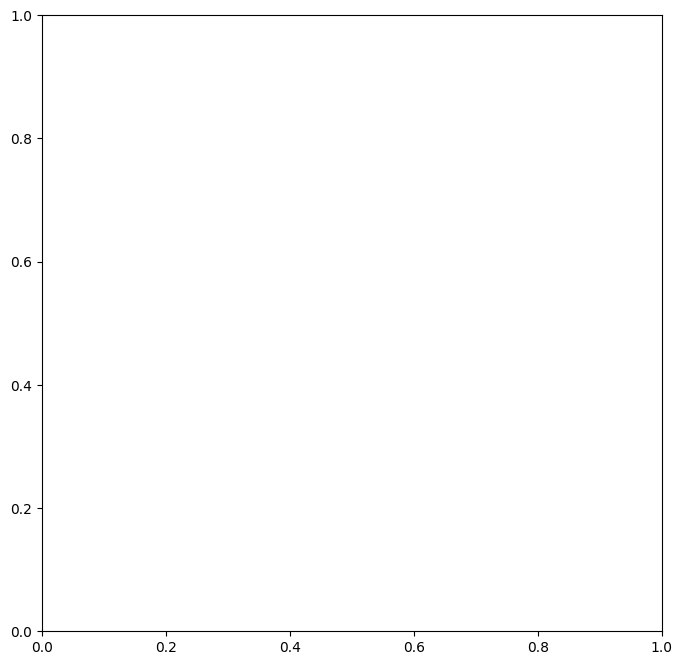

In [5]:
# Etiqueta para los nodos: Usaremos el índice del nodo
g = user_graph
# Puedes usar g.vs["name"] si prefieres mostrar los nombres asignados
g.vs["label"] = [str(i) for i in range(g.vcount())]

# Etiquetas para las aristas: Usaremos el peso de las aristas
# Formatear el peso para que no tenga demasiados decimales
g.es["label"] = [f"{w:.2f}" for w in g.es["weight"]]

# 2. Definir el layout del grafo
# El layout determina la posición de los nodos en el dibujo.
# Hay varios algoritmos disponibles:
# - 'auto': igraph intenta elegir el mejor.
# - 'kk': Kamada-Kawai (bueno para grafos con estructura).
# - 'fr': Fruchterman-Reingold (bueno para grafos generales).
# - 'circle': Nodos en un círculo.
# - 'grid': Nodos en una cuadrícula.
# - 'tree': Para árboles.
layout = g.layout("fr") # Usando el algoritmo Fruchterman-Reingold

# 3. Graficar el grafo
# Usamos el método plot de igraph, que internamente usa matplotlib.
fig, ax = plt.subplots(figsize=(8, 8)) # Crear una figura y ejes para mayor control

ig.plot(
    g,
    target=ax, # Especificar los ejes de matplotlib para dibujar
    layout=layout,
    vertex_label=g.vs["label"], # Mostrar el índice del nodo como etiqueta
    edge_label=g.es["label"],   # Mostrar el peso de la arista como etiqueta
    edge_color="gray",
    bbox=(600, 600), # Tamaño del bounding box para el dibujo
    margin=20, # Margen alrededor del grafo
    autocurve=True # Curvar las aristas si hay múltiples entre los mismos nodos
)


## Optimización

In [6]:
import os
import igraph as ig
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as st
import matplotlib.pyplot as plt
from collections import defaultdict

# Función para cargar grafos desde un directorio
def load_graphs_from_directory(directory):
    graphs = []
    graph_names = []
    for filename in os.listdir(directory):
        if filename.endswith(".graphml"):
            graph = ig.Graph.Read_GraphML(os.path.join(directory, filename))
            graphs.append(graph)
            graph_names.append(filename)
    return graphs, graph_names

# Función para calcular las métricas para cada grafo
def calculate_metrics(graph, bigraph, avg_path_bip):
    user_nodes = bigraph.vs.select(type=0)
    res_nodes = bigraph.vs.select(type=1)
    bidensity = bigraph.ecount() / (len(user_nodes) * len(res_nodes))

    density = abs(graph.density() - bidensity)
    components = len(graph.components())
    modularity = 1 - graph.modularity(graph.community_multilevel())
    clustering_coefficient = graph.transitivity_avglocal_undirected()
    clustering_coefficient = abs(clustering_coefficient-bigraph.transitivity_avglocal_undirected())
    avg_degree = 2 * graph.ecount() / graph.vcount() if graph.vcount() > 0 else 0
    avg_degree = abs(avg_degree-st.mean(bigraph.degree()))
    # Calcular avg_path_length sobre el componente más grande si el grafo no está conectado
    if graph.is_connected():
        avg_path_length = graph.average_path_length()
        avg_path_length = abs(avg_path_length-avg_path_bip)
    else:
        largest_component = max(graph.components(), key=len,default=0)
        if largest_component != 0:
            subgraph = graph.subgraph(largest_component)
            avg_path_length = subgraph.average_path_length()
            avg_path_length = abs(avg_path_length-avg_path_bip)
        else:
            avg_path_length = 0


    metrics = {
        "density": density,
        "components": components,
        "modularity": modularity,
        "clustering_coefficient": clustering_coefficient,
        "avg_degree": avg_degree,
        "avg_path_length": avg_path_length
    }
    return metrics

# Función para determinar si un grafo domina a otro
def dominates(graph_a, graph_b, metrics):
    dominates_flag = False
    for metric in metrics.keys():
        if metrics[metric]["optimize"] == "minimize":
            if graph_a[metric] > graph_b[metric]:
                return False
            if graph_a[metric] <=  graph_b[metric]:
                dominates_flag = True
        elif metrics[metric]["optimize"] == "maximize":
            if graph_a[metric] < graph_b[metric]:
                return False
            if graph_a[metric] > graph_b[metric]:
                dominates_flag = True
    return dominates_flag

# Función para calcular los frentes de Pareto
def calculate_pareto_fronts(graph_metrics):
    pareto_fronts = []
    remaining_graphs = list(graph_metrics.items())
    
    while remaining_graphs:
        current_front = []
        for i, (graph_i, metrics_i) in enumerate(remaining_graphs):
            dominated = False
            for j, (graph_j, metrics_j) in enumerate(remaining_graphs):
                if i != j and dominates(metrics_j, metrics_i, metrics_definitions):
                    dominated = True
                    break
            if not dominated:
                current_front.append((graph_i, metrics_i))
        pareto_fronts.append(current_front)
        remaining_graphs = [graph for graph in remaining_graphs if graph not in current_front]
    
    return pareto_fronts

# Función para preparar los datos de las métricas y frentes de Pareto
def prepare_parallel_coordinates_data(pareto_fronts, graph_names):
    data = []
    id_to_name = {i: graph_names[i] for i in range(len(graph_names))}

    for level, front in enumerate(pareto_fronts):
        for graph_id, metrics in front:
            row = {
                "ID": graph_id,
                "Pareto Level": level + 1,
                **metrics
            }
            data.append(row)

    return pd.DataFrame(data), id_to_name

def visualize_parallel_coordinates(df, id_to_name):
    # Configurar el estilo de Seaborn
    sns.set_theme(style="whitegrid")

    # Crear figura
    plt.figure(figsize=(15, 8))

    # Lista de colores para cada frente de Pareto
    colors = sns.color_palette("tab10", len(df["Pareto Level"].unique()))

    # Trazar líneas por cada grafo
    for idx, row in df.iterrows():
        metrics = row.drop(["ID", "Pareto Level"])
        pareto_level = int(row["Pareto Level"])  # Convertir nivel de Pareto a entero
        plt.plot(metrics.index, metrics.values, label=f"ID {row['ID']}", color=colors[pareto_level - 1], linewidth=1.5)

        # Agregar el identificador al final de cada línea
        plt.text(
            len(metrics) - 1,  # Posición X al final de las métricas
            metrics.values[-1],  # Último valor Y
            f"{row['ID']}",  # Texto del identificador
            fontsize=9,
            color=colors[pareto_level - 1],
            va="center"
        )

    # Ajustar etiquetas y leyendas
    plt.title("Parallel Coordinates Plot: Metrics Across Pareto Levels", fontsize=14)
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)

    # Leyenda de niveles de Pareto
    for level in df["Pareto Level"].unique():
        plt.plot([], [], color=colors[int(level) - 1], label=f"Pareto Level {int(level)}")
    plt.legend(title="Pareto Level", loc="upper left", bbox_to_anchor=(1, 1))

    # Mostrar gráfica
    plt.tight_layout()
    plt.show()

    # Mostrar tabla de identificadores
    print("\nGraph Identifiers:")
    for graph_id, graph_name in id_to_name.items():
        print(f"ID {graph_id}: {graph_name}")

def visualize_2d_coordinates(df, metric_x, metric_y, id_to_name):
    """
    Visualiza en 2D las métricas seleccionadas para cada nivel de Pareto.

    :param df: DataFrame que contiene las métricas, niveles de Pareto e identificadores de los grafos.
    :param metric_x: Métrica para el eje X.
    :param metric_y: Métrica para el eje Y.
    :param id_to_name: Diccionario que mapea los IDs de grafos a sus nombres.
    """
    # Configurar el estilo de Seaborn
    sns.set_theme(style="whitegrid")

    # Crear figura
    plt.figure(figsize=(12, 8))

    # Lista de colores para cada frente de Pareto
    colors = sns.color_palette("tab10", len(df["Pareto Level"].unique()))

    # Graficar cada punto y conectar con líneas
    for idx, row in df.iterrows():
        pareto_level = int(row["Pareto Level"])  # Convertir nivel de Pareto a entero
        graph_id = row["ID"]
        
        x_val = row[metric_x]
        y_val = row[metric_y]

        # Trazar puntos en 2D y conectar con líneas si necesario
        plt.scatter(x_val, y_val, color=colors[pareto_level - 1], s=80, label=f"ID {graph_id}" if idx == 0 else "", alpha=0.8)

        # Agregar el identificador al final de cada punto
        plt.text(
            x_val, 
            y_val, 
            f"{graph_id}", 
            fontsize=9, 
            color=colors[pareto_level - 1], 
            va="center", 
            ha="center", 
            alpha=0.8
        )

    # Ajustar etiquetas y leyendas
    plt.title(f"2D Coordinate Visualization: {metric_x} vs {metric_y}", fontsize=14)
    plt.xlabel(metric_x, fontsize=12)
    plt.ylabel(metric_y, fontsize=12)
    plt.grid(True)

    # Leyenda de niveles de Pareto
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title="Graph ID", loc="upper left", bbox_to_anchor=(1, 1))

    # Mostrar gráfica
    plt.tight_layout()
    plt.show()

    # Mostrar tabla de identificadores
    print("\nGraph Identifiers:")
    for graph_id, graph_name in id_to_name.items():
        print(f"ID {graph_id}: {graph_name}")


# Definición de las métricas y sus objetivos
metrics_definitions = {
    "density": {"optimize": "minimize"},
    "components": {"optimize": "minimize"},
    "modularity": {"optimize": "minimize"},
    "clustering_coefficient": {"optimize": "maximize"},
    "avg_degree": {"optimize": "minimize"},
    "avg_path_length": {"optimize": "minimize"}
}

In [7]:
directory = "../data/HC/bot"  # Cambia esta ruta
graphs, graph_names = load_graphs_from_directory(directory)

#bigraph = ig.read("user-movie-lens.graphml")
#bigraph = ig.read("../data/AMZ/PosBinet-AMZ.graphml")
bigraph = ig.read("../data/HC/binet-HC-Rw.gml")

avg_path_bip = bigraph.average_path_length()

graph_metrics = {}
for i, graph in enumerate(graphs):
    metrics = calculate_metrics(graph, bigraph, avg_path_bip)
    graph_metrics[i] = metrics

pareto_fronts = calculate_pareto_fronts(graph_metrics)
df, id_to_name = prepare_parallel_coordinates_data(pareto_fronts, graph_names)
print(df)
print(id_to_name)

FileNotFoundError: [Errno 2] No such file or directory: '../data/HC/bot'